libraries

In [19]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

load data

In [20]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()

# w2v 피쳐 사용

In [21]:
### Make corpus
p_level = 'gds_grp_mclas_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
# unique 사용하지 않음.

def oversample(x, n=1, seed=0):   
    np.random.seed(seed)
    ids = x['cust_id'].unique().tolist() 
    Products = []
    
    for id_s in ids:    
        productList = x.query(f'cust_id == {id_s}')[p_level].tolist()
        for i in range(n):
            productList = list(np.append(productList, np.random.choice(productList, len(productList)*n, replace=True)))  # 복원추출 사용.
        Products.append(productList)
    return Products

X_train = oversample(df_train, 2)
X_test = oversample(df_test, 2)

### Training the Word2Vec model
num_features = 300 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 10 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(X_train, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        sg=1, # sg=1, workers=4 사용. sg=1 로 skip-gram방식 채택
                        seed=0, workers=4)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)

### Make features
# 구매상품에 해당하는 벡터의 최대/분산/표준편차 벡터를 feature로 만드는 전처리기(pipeline에서 사용 가능)
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.var([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ])  
    
# EmbeddingVectorizer 클래스를 통해서 피쳐뽑기

Vectorizer = EmbeddingVectorizer(w2v.wv)
Vectorizer.fit(X_train, y_train)

X_train_new = pd.DataFrame(Vectorizer.transform(X_train))
X_test_new = pd.DataFrame(Vectorizer.transform(X_test))

X_train_new

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.073661,0.143001,0.062736,0.181693,0.081275,0.121119,0.081626,0.147137,0.077073,0.029350,...,1.831347e-03,1.309530e-03,5.887108e-04,8.706888e-04,2.404028e-03,0.002937,3.724894e-03,1.776510e-03,2.880717e-03,0.001341
1,-0.014247,0.041688,0.002222,0.088977,0.011558,0.121119,0.088454,0.093546,0.025100,0.017685,...,3.587185e-03,3.635426e-05,1.509667e-04,6.940352e-06,3.204737e-03,0.007679,5.611323e-07,1.787126e-03,1.612345e-05,0.000039
2,-0.024683,0.247794,-0.009898,0.175974,-0.002187,0.051169,0.039046,0.121887,0.065389,-0.038562,...,4.742717e-03,9.366500e-05,1.692523e-04,2.392999e-06,1.626161e-04,0.000008,3.246493e-04,2.195657e-04,1.540998e-03,0.000559
3,0.065949,0.143839,0.111519,0.113842,0.063452,0.164563,0.137870,0.147137,0.098674,0.045073,...,2.001211e-03,4.079410e-04,2.533661e-04,8.824553e-04,6.764220e-04,0.001716,1.994024e-03,7.882088e-04,3.139941e-03,0.000492
4,0.073661,0.130383,-0.009898,0.081558,0.021276,0.082945,0.035784,0.121887,0.125757,-0.031136,...,1.104850e-03,8.646961e-04,4.761621e-04,5.659188e-04,3.072132e-03,0.000440,6.517876e-04,2.672682e-05,1.072253e-03,0.000982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.005253,0.130383,0.019988,0.072352,-0.026763,0.020230,0.057501,0.121887,0.065389,0.029350,...,1.426532e-03,1.979043e-03,7.169532e-04,1.335319e-03,9.222854e-04,0.003937,2.473336e-03,2.959961e-03,4.525156e-04,0.001561
3496,0.011504,0.138310,0.019988,0.124221,0.005628,0.067018,0.057501,0.121887,0.077073,0.029350,...,8.122765e-04,8.646743e-04,2.831878e-04,7.453368e-04,1.030853e-03,0.001731,6.867272e-04,3.435219e-03,8.888706e-04,0.001002
3497,0.014022,0.095432,-0.143003,0.122673,0.022131,-0.046907,-0.020492,-0.037374,0.033576,-0.100427,...,8.673617e-19,3.469447e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3498,0.073661,0.042196,-0.035062,0.081558,0.021276,-0.030754,-0.084377,0.018213,0.026492,-0.031136,...,5.551115e-17,1.387779e-17,1.219727e-19,1.249001e-16,3.469447e-18,0.000000,5.551115e-17,1.387779e-17,3.469447e-18,0.000000


In [22]:
### Read data

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()


y_train.gender = y_train.gender.astype(str)

tr = pd.merge(df_train, y_train, on='cust_id')
tr2 = pd.concat([df_train, df_test])

corpus_goods = []
corpus_nm = []
corpus_mclas = []

for i in range(len(tr)):
    
    goods = tr.loc[i, 'goods_id']
    nm = tr.loc[i, 'gds_grp_nm']
    mclas = tr.loc[i, 'gds_grp_mclas_nm']
    gen = tr.loc[i, 'gender']
    
    corpus_goods.append([goods, gen])
    corpus_nm.append([nm, gen])
    corpus_mclas.append([mclas, gen])
    
tr['corpus_goods'] = corpus_goods
tr['corpus_nm'] = corpus_nm
tr['corpus_mclas'] = corpus_mclas

corpus_df = pd.DataFrame(tr.groupby('cust_id')['corpus_goods'].agg(lambda x: [j for i in x for j in i]))
corpus_df['corpus_nm'] = tr.groupby('cust_id')['corpus_nm'].agg(lambda x: [j for i in x for j in i])
corpus_df['corpus_mclas'] = tr.groupby('cust_id')['corpus_mclas'].agg(lambda x: [j for i in x for j in i])

display(corpus_df)

corpus1 = corpus_df['corpus_goods']
corpus2 = corpus_df['corpus_nm']
corpus3 = corpus_df['corpus_mclas']

def oversample2(data, n=1, seed=0):    
    
    np.random.seed(seed)
    
    customerProducts = []
    
    for cor in data:
            
        cor = list(np.append(cor, np.random.choice(cor, len(cor) * n, replace=True)))
        
        customerProducts.append(cor)
    
    return customerProducts

corpus1_sam = oversample2(corpus1, n=20, seed=0)
corpus2_sam = oversample2(corpus2, n=20, seed=0)
corpus3_sam = oversample2(corpus3, n=20, seed=0)

# W2V 학습

num_features = 20 # 문자 벡터 차원 수
min_word_count = 0 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기

wv_item1 = word2vec.Word2Vec(corpus1_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item2 = word2vec.Word2Vec(corpus2_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item3 = word2vec.Word2Vec(corpus3_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

## goods_id

def get_0_similarity_goods(product):
    try:
        sim = wv_item1.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_goods(product):
    try:
        sim = wv_item1.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_nm

def get_0_similarity_nm(product):
    try:
        sim = wv_item2.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_nm(product):
    try:
        sim = wv_item2.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_mclas_nm

def get_0_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim


tr2['goods_0_similarity'] = tr2['goods_id'].apply(get_0_similarity_goods)
tr2['goods_1_similarity'] = tr2['goods_id'].apply(get_1_similarity_goods)
tr2['nm_0_similarity'] = tr2['gds_grp_nm'].apply(get_0_similarity_nm)
tr2['nm_1_similarity'] = tr2['gds_grp_nm'].apply(get_1_similarity_nm)
tr2['mclas_0_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_0_similarity_mclas)
tr2['mclas_1_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_1_similarity_mclas)

train_test = pd.DataFrame({'cust_id' : range(5982)}).set_index('cust_id')

train_test['goods_0_similarity'] = tr2.groupby('cust_id')['goods_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['goods_1_similarity'] = tr2.groupby('cust_id')['goods_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_0_similarity'] = tr2.groupby('cust_id')['nm_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_1_similarity'] = tr2.groupby('cust_id')['nm_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_0_similarity'] = tr2.groupby('cust_id')['mclas_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_1_similarity'] = tr2.groupby('cust_id')['mclas_1_similarity'].apply(lambda x: np.nanmean(x))


X_train_w2v = train_test[:3500]
X_test_w2v = train_test[3500:]

idx = [i for i in range(3500,5982)]

X_test_new['cust_id'] = idx
X_test_new = X_test_new.set_index('cust_id')

X_train_new = pd.concat([X_train_w2v, X_train_new], axis=1)
X_test_new = pd.concat([X_test_w2v, X_test_new], axis=1)
X_test_new = X_test_new.fillna(X_test_new.mean())

,corpus_goods,corpus_nm,corpus_mclas
cust_id,,,
0,"[127105, 0, 342220, 0, 127105, 0, 342205, 0, 3...","[기초 화장품, 0, 니 트, 0, 기초 화장품, 0, 니 트, 0, 상품군미지...","[화장품, 0, 시티웨어, 0, 화장품, 0, 시티웨어, 0, 기타, 0, 화장품,..."
1,"[550231, 0, 550231, 0, 462102, 0]","[아웃도아, 0, 아웃도아, 0, 트래디셔널Ⅰ, 0]","[스포츠, 0, 스포츠, 0, 트래디셔널, 0]"
2,"[461119, 1, 461119, 1, 461119, 1, 461119, 1]","[시티캐주얼, 1, 상품군미지정, 1, 상품군미지정, 1, 시티캐주얼, 1]","[남성 캐주얼, 1, 기타, 1, 기타, 1, 남성 캐주얼, 1]"
3,"[35145, 1, 821104, 1, 32263, 1, 50114, 1, 5010...","[회, 1, 한실침구, 1, 생선, 1, 일반가공식품, 1, 일반가공식품, 1, 일...","[수산품, 1, 침구/수예, 1, 수산품, 1, 가공식품, 1, 가공식품, 1, 가..."
4,"[127109, 0, 150124, 0, 150124, 0]","[기초 화장품, 0, 상품군미지정, 0, 보석, 0]","[화장품, 0, 기타, 0, 보석, 0]"
...,...,...,...
3495,"[143102, 1, 143102, 1]","[L/C골프의류, 1, 상품군미지정, 1]","[골프, 1, 기타, 1]"
3496,"[405107, 1, 173197, 1, 381116, 1, 996101, 1, 3...","[N.B정장, 1, 캐릭터 여화, 1, 시니어, 1, 상품군미지정, 1, 인텔리젼스...","[남성정장, 1, 구두, 1, 시티웨어, 1, 기타, 1, 시티웨어, 1, 시티웨어..."
3497,"[647178, 0]","[국산주방, 0]","[주방용품, 0]"


## BOW1

In [23]:
# 788 BOW 피쳐(상관관계, 모든전처리, percentile 이후)

X_train = pd.read_csv('X_train_after_preprocessing.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_preprocessing.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

In [32]:
idx = [i for i in range(3500,5982)]

X_test['cust_id'] = idx
X_test = X_test.set_index('cust_id')

X_train_new = pd.concat([X_train_new, X_train],axis=1)
X_test_new = pd.concat([X_test_new, X_test],axis=1)

In [33]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)

models = [logreg]

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [11:24<00:00,  7.21s/it]
No handles with labels found to put in legend.


LogisticRegression (77, 0.7717970985448189)


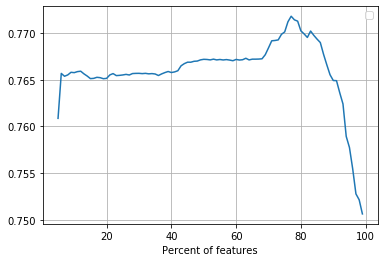

In [34]:
skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기 <- 처음에만 100프로 찍고 이후 조절하기
    for percentile in tqdm(range(5,100)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train_new,y_train)
       
        # cross_val_score 4번의 평균값 (정수시 skf로 자동으로 들어간다)
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [35]:
select_p = SelectPercentile(percentile=best_score[0]).fit(X_train_new, y_train)
X_train = select_p.transform(X_train_new)
X_test = select_p.transform(X_test_new)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [37]:
X_train

array([[ 0.37867364, -0.05715041,  0.20966873, ..., -0.29152507,
        -0.39175273, -0.1127275 ],
       [ 0.07758634, -0.12215102,  0.29104076, ...,  0.55159497,
         0.19073178, -0.15404818],
       [ 0.27840203, -0.13902063,  0.41165197, ...,  0.13370314,
         0.12266328, -0.06594497],
       ...,
       [ 0.22171068,  0.15928626,  0.25361228, ..., -0.16335834,
         0.22841814,  0.08854428],
       [ 0.03066001,  0.15422905,  0.14090319, ...,  0.41114916,
        -0.14484217,  0.07505889],
       [ 0.14472225,  0.12691832,  0.12643603, ...,  0.03029854,
         0.00956179,  0.09911007]])

In [38]:
X_test

array([[-0.14562334,  0.10719953,  0.05285758, ...,  0.32201607,
        -0.04525061, -0.01069687],
       [ 0.19801814,  0.06391473,  0.29767962, ...,  0.27814712,
         0.05287843,  0.15137349],
       [ 0.30969061,  0.2307281 ,  0.26682428, ...,  0.54759254,
        -0.33862039, -0.19183876],
       ...,
       [-0.09113634,  0.07615984,  0.05433874, ...,  0.24774476,
        -0.05869528, -0.43019876],
       [ 0.19981894,  0.13745643,  0.17305795, ...,  0.26010963,
         0.21809215,  0.04388484],
       [ 0.27517988,  0.28945869,  0.17800564, ..., -0.07337788,
        -0.00379592, -0.13430358]])

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

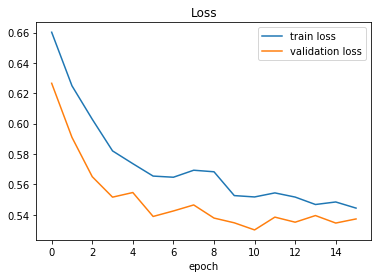

 20%|████████████████▊                                                                   | 1/5 [00:01<00:06,  1.59s/it]

0.7897071490094745


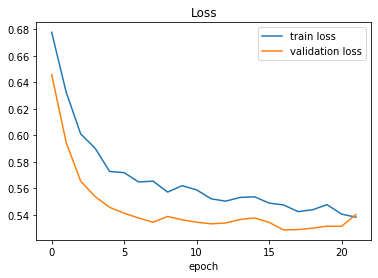

 40%|█████████████████████████████████▌                                                  | 2/5 [00:03<00:04,  1.65s/it]

0.7895434969853575


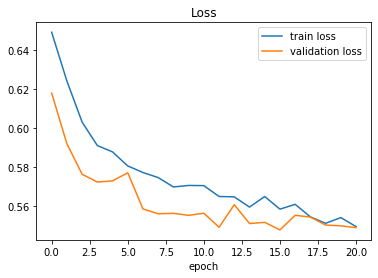

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:05<00:03,  1.68s/it]

0.7851636520241172


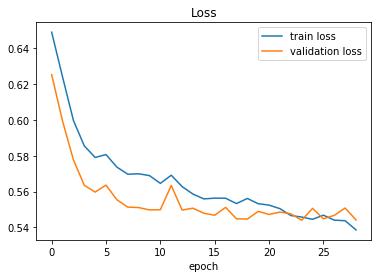

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:07<00:01,  1.80s/it]

0.7860077519379846


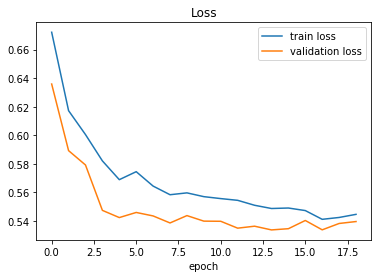

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]

0.7935658914728683


In [39]:
for i in tqdm(range(5)):       
    # model architecture
    model = Sequential(name = 'dnn model')
    model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # choose the optimizer and the cost function
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    # model.summary()


    # train the model -> verbose=0: silent
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
        batch_size=64, epochs=200, callbacks=callbacks, verbose=0)

    # visualize training history
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.show()


    # plt.plot(hist.history['acc'], label='train acc')
    # plt.plot(hist.history['val_acc'], label='validation acc')
    # plt.legend()
    # plt.xlabel('epoch')
    # plt.title('acc')
    # plt.show()

    # evaluate the model performance

    #print(model.evaluate(X_test, y_test))
    #if roc_auc_score(y_test, model.predict(X_test)) >= 0.755:
    #    print(f'1층: {dr1},드롭1: {drop1},2층: {dr2}, 드롭2: {drop2}, 3층: {dr3}')
    #    print(roc_auc_score(y_test, model.predict(X_test)))
    print(roc_auc_score(y_valid, model.predict(X_valid)))

In [40]:
pred = model.predict(X_test).flatten()
print(pred.shape)


(2482,)


In [41]:
ID_dep = [i for i in range(3500,5982)]

In [42]:
# make submissions

# pd.DataFrame({'cust_id': ID_dep, 'gender': pred}).to_csv('submission_w2v대 dnn.csv', index=False, encoding='cp949')
# pd.read_csv('submission_w2v대 dnn.csv', encoding='cp949')

## +ref_dnn modeling

In [43]:
# 모형 학습 시 RMSE를 계산하는 함수
import keras.backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [44]:
# 예측값을 저장할 폴더 생성
folder = 'Ensemble'
if not os.path.isdir(folder):
    os.mkdir(folder)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

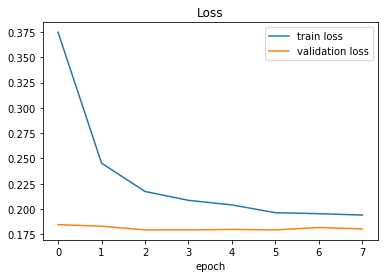

 20%|████████████████▊                                                                   | 1/5 [00:01<00:07,  1.95s/it]

0.7923858742463395 SEED: 3968


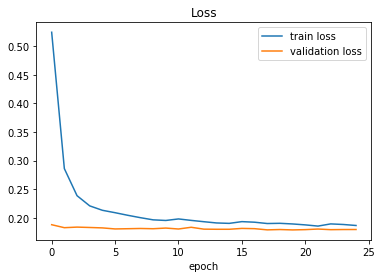

 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:06,  2.14s/it]

0.7949181739879414 SEED: 3985


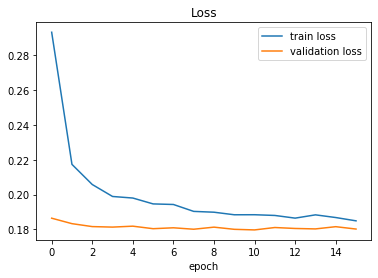

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:04,  2.09s/it]

0.7919379844961241 SEED: 1879


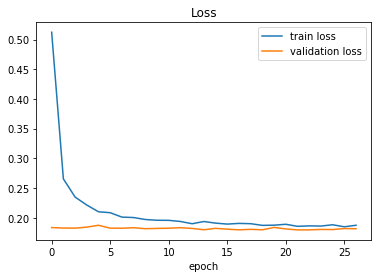

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:09<00:02,  2.29s/it]

0.7928768303186908 SEED: 3880


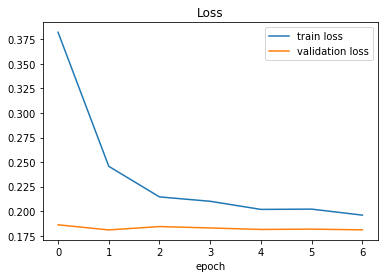

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]

0.7934797588285961 SEED: 9361


In [45]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='elu')(x)
    model = Model(input, output)  

    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])

    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                    callbacks=callbacks, shuffle=False, verbose=0)
    
    # visualize training history
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.show()

    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)


    # Make submissions
#     submission = pd.DataFrame({
#         "item_id": IDtest, 
#         "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
#     })
#     t = pd.Timestamp.now()
#     fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)    
 

In [ ]:
# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="item_id")
#     nf += 1

# p = 4.5 # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)    
# if nf >= 2:
#     pred = 0
#     for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
#     pred = pred / nf    
#     pred = pred**(1/p)

#     submission = pd.DataFrame({'cust_id': slist.item_id, 'gender': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_dnn_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)

In [ ]:
# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="item_id")
#     nf += 1

# p = 3.5 # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)    
# if nf >= 2:
#     pred = 0
#     for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
#     pred = pred / nf    
#     pred = pred**(1/p)

#     submission = pd.DataFrame({'cust_id': slist.item_id, 'gender': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_dnn_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)